In [2]:
import numpy as np
import math
from scipy.stats import chi2
import matplotlib.pyplot as plt
from scipy.stats import uniform
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import ksone
from scipy.stats import norm
from scipy.stats import chisquare
from scipy.stats import expon
from scipy.stats import multivariate_normal
from scipy.stats import pareto
from scipy.stats import t
from mpl_toolkits.mplot3d import Axes3D

In [161]:
def GenerateStateTime(w_1,w_2,States):
    if type(States) != list:
        if States==1:
            StateTimes = -np.log(np.random.random())/w_1
        else:
            StateTimes = -np.log(np.random.random())/w_2
    return StateTimes

In [113]:
def GenerateServiceTime(servicemean,N):
    return -np.log(np.random.rand(N))*servicemean

In [114]:
def GenerateArrivalTime(lmbda,N):
    return -np.log(np.random.rand(N))/lmbda

In [115]:
def DepositToQueue(arrtime,Q,Ql):
    #T is the curret time
    #arrtime is the arrival time
    #Q is current queue
    #Ql is the queue lengths with corresponding time
    if arrtime:
        Q.append(arrtime)
        if Q:
            Ql.append([arrtime,len(Q)])
        else:
            Ql.append([arrtime,0])
    else:
        pass

In [116]:
def DrawFromQueue(T,Q,Ql,Qt,S):
    #T is current time
    #Q is current queue
    #Qt is total queue waiting times
    #S is server status
    #s is service time mean
    #Ql is the queue lengths with corresponding time
    Qt.append(T-Q[0])
    Q.pop(0)
    if Q:
        Ql.append([T,len(Q)])
    else:
        Ql.append([T,0])
    S = 1
    return S

In [199]:
def SimQueueIPP(N,servicemean,w_1,w_2,lmbda,K,L):
    import heapq
    #N is the number of units
    #s is the service time mean
    #w_1 is the frequency to switching from ON to OFF
    #w_2 is the frequency to switching from OFF to ON
    #lmbda is the arrival intensity
    #L is the superpositions
    Q = []
    Qt = []
    Ql = []
    M = 0
    S = np.zeros((N,))
    States = np.ones((L,))
    T = 0
    events = []
    arrival = GenerateArrivalTime(lmbda,L)
    for l in range(L):
        heapq.heappush(events,(GenerateStateTime(w_1,w_2,1),('StateChange',l)))
    for indx,e in enumerate(arrival):
        heapq.heappush(events,(e,('Arrival',indx)))
    k = 0
    As = np.ones((L,))
    while(k<K):
        print(list(events))
        #print(Ql)
        event = heapq.heappop(events)
        T = event[0]
        if event[1][0]=='StateChange':
            indx = event[1][1]
            if States[indx]==0:
                States[indx] = 1
                statetime = GenerateStateTime(w_1,w_2,States[indx])
                heapq.heappush(events,(statetime+T,('StateChange',indx)))
                if As[indx] == 0:
                    arrivaltime = GenerateArrivalTime(lmbda,1)[0]
                    heapq.heappush(events,(arrivaltime+T,('Arrival',indx)))
            else:
                States[indx] = 0
                statetime = GenerateStateTime(w_1,w_2,States[indx])
                heapq.heappush(events,(statetime+T,('StateChange',indx)))
        elif event[1][0]=='Arrival':
            indx = event[1][1]
            As[indx] = 0
            if States[indx]==0:
                continue
            else:
                arrivaltime = GenerateArrivalTime(lmbda,1)[0]
                if np.any(S==0):
                    serverindx = np.argmax(S==0)
                    servicetime = GenerateServiceTime(servicemean,1)[0]
                    heapq.heappush(events,(servicetime+T,('Service',serverindx)))
                    heapq.heappush(events,(arrivaltime+T,('Arrival',indx)))
                    S[serverindx] = 1
                else:
                    DepositToQueue(T,Q,Ql)
                    heapq.heappush(events,(arrivaltime+T,('Arrival',indx)))
                    M += 1
        elif event[1][0]=='Service':
            indx = event[1][1]
            S[indx] = 0
            k+=1
            #print(Ql)
            if Q:
                S[indx] = DrawFromQueue(T,Q,Ql,Qt,S[indx])
                servicetime = GenerateServiceTime(servicemean,1)[0]
                heapq.heappush(events,(servicetime+T,('Service',indx)))
            else:
                continue
    return Ql,Qt,M

In [157]:
Ms = []
for i in range(100):
    Ql,Qt,M=SimQueueIPP(10,8,2,2,1,10000,1)
    Ms.append(M)
mean = np.mean(Ms) 
print(mean)
S = np.var(Ms,ddof=1)
print([mean+t.ppf(0.025,100)*np.sqrt(S)/np.sqrt(100),mean+t.ppf(0.975,100)*np.sqrt(S)/np.sqrt(100)])

4092.69
[4038.1042211194535, 4147.2757788805466]


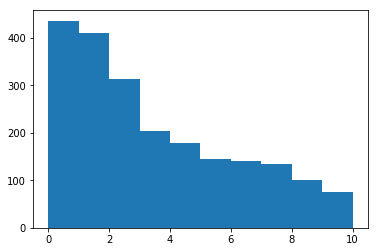

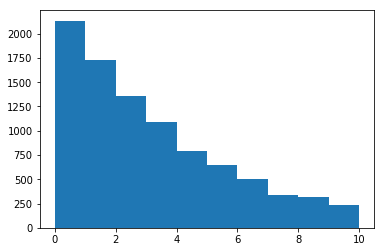

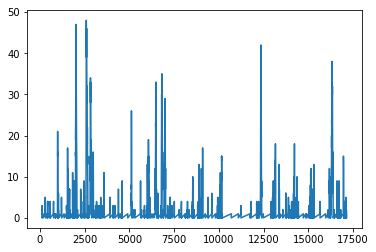

In [203]:
plt.figure()
plt.hist(Qt,bins=np.linspace(0,10,11))
plt.figure()
plt.hist(probs,bins=np.linspace(0,10,11))
Ql = np.array(Ql)
plt.figure()
plt.plot(Ql[:,0],Ql[:,1])
plt.show()

In [200]:
Ql,Qt,M=SimQueueIPP(10,8,1/8,1/8,1,10000,1)

[(1.8551602038362012, ('Arrival', 0)), (3.6786769400757149, ('StateChange', 0))]
[(1.9215341025222583, ('Arrival', 0)), (15.202015033370001, ('Service', 0)), (3.6786769400757149, ('StateChange', 0))]
[(2.752670280068084, ('Arrival', 0)), (3.6786769400757149, ('StateChange', 0)), (11.989518928286831, ('Service', 1)), (15.202015033370001, ('Service', 0))]
[(3.3075532654316522, ('Arrival', 0)), (3.6786769400757149, ('StateChange', 0)), (11.989518928286831, ('Service', 1)), (15.202015033370001, ('Service', 0)), (7.5825622117690585, ('Service', 2))]
[(3.6786769400757149, ('StateChange', 0)), (7.5825622117690585, ('Service', 2)), (4.8952563328889562, ('Arrival', 0)), (15.202015033370001, ('Service', 0)), (10.007243438330562, ('Service', 3)), (11.989518928286831, ('Service', 1))]
[(4.8952563328889562, ('Arrival', 0)), (7.5825622117690585, ('Service', 2)), (11.989518928286831, ('Service', 1)), (15.202015033370001, ('Service', 0)), (10.007243438330562, ('Service', 3)), (25.216560399649445, ('St

[(1284.438926981222, ('Service', 5)), (1285.2821655908524, ('Arrival', 0)), (1286.4065909472899, ('StateChange', 0)), (1287.4893214266078, ('Service', 2)), (1298.7188934928606, ('Service', 3)), (1291.0985751588087, ('Service', 1)), (1288.0114656687074, ('Service', 0)), (1305.1627591280289, ('Service', 6)), (1295.3814236836088, ('Service', 4))]
[(1285.2821655908524, ('Arrival', 0)), (1287.4893214266078, ('Service', 2)), (1286.4065909472899, ('StateChange', 0)), (1295.3814236836088, ('Service', 4)), (1298.7188934928606, ('Service', 3)), (1291.0985751588087, ('Service', 1)), (1288.0114656687074, ('Service', 0)), (1305.1627591280289, ('Service', 6))]
[(1285.757411526137, ('Arrival', 0)), (1286.4065909472899, ('StateChange', 0)), (1288.0114656687074, ('Service', 0)), (1287.4893214266078, ('Service', 2)), (1298.7188934928606, ('Service', 3)), (1291.0985751588087, ('Service', 1)), (1305.1627591280289, ('Service', 6)), (1295.3814236836088, ('Service', 4)), (1293.8645031369881, ('Service', 5))]

[(2621.7129242329338, ('Service', 8)), (2621.7132709278826, ('Service', 7)), (2622.3462454947598, ('Arrival', 0)), (2625.3189576506761, ('Service', 3)), (2623.1795410429727, ('Service', 1)), (2622.8959485307628, ('Service', 5)), (2656.5795898465458, ('Service', 2)), (2630.8568311441882, ('Service', 0)), (2629.9500023255355, ('StateChange', 0)), (2630.204747400147, ('Service', 9)), (2624.070574210381, ('Service', 6)), (2627.78702185164, ('Service', 4))]
[(2621.7132709278826, ('Service', 7)), (2623.1795410429727, ('Service', 1)), (2622.3462454947598, ('Arrival', 0)), (2625.3189576506761, ('Service', 3)), (2624.070574210381, ('Service', 6)), (2622.8959485307628, ('Service', 5)), (2656.5795898465458, ('Service', 2)), (2630.8568311441882, ('Service', 0)), (2629.9500023255355, ('StateChange', 0)), (2630.204747400147, ('Service', 9)), (2627.78702185164, ('Service', 4)), (2634.4703689001549, ('Service', 8))]
[(2622.3462454947598, ('Arrival', 0)), (2623.1795410429727, ('Service', 1)), (2622.895

[(4501.1547598480847, ('Arrival', 0)), (4502.0166511719017, ('Service', 0)), (4508.7227636631715, ('Service', 1)), (4503.7895486826101, ('Service', 3)), (4512.3664755464024, ('Service', 6)), (4522.2766241884819, ('Service', 8)), (4515.6223136383023, ('StateChange', 0)), (4517.4786677726379, ('Service', 9)), (4504.305131087267, ('Service', 2))]
[(4501.3938777185776, ('Arrival', 0)), (4502.0166511719017, ('Service', 0)), (4508.7227636631715, ('Service', 1)), (4504.305131087267, ('Service', 2)), (4503.7895486826101, ('Service', 3)), (4522.2766241884819, ('Service', 8)), (4515.6223136383023, ('StateChange', 0)), (4517.4786677726379, ('Service', 9)), (4508.3586646229905, ('Service', 4)), (4512.3664755464024, ('Service', 6))]
[(4502.0166511719017, ('Service', 0)), (4502.0741210296183, ('Service', 5)), (4508.7227636631715, ('Service', 1)), (4504.305131087267, ('Service', 2)), (4503.0780054434954, ('Arrival', 0)), (4522.2766241884819, ('Service', 8)), (4515.6223136383023, ('StateChange', 0)), 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [55]:
strcomp('hey','hey')

NameError: name 'strcomp' is not defined

In [202]:

probs=-1/2*np.log(np.random.rand(10000))*8
probs = probs-1/2*np.log(np.random.rand(10000))/8

In [178]:
np.

array([], dtype=float64)